# Jaccard Similarity

**Created**: November 9 2021

## Environment

In [1]:
rm(list=ls())

if (!require("pheatmap")) {
    install.packages("pheatmap")
}

Loading required package: pheatmap



In [2]:
library(tidyverse)
library(MASS)
library(RColorBrewer)
library(patchwork)
library(pheatmap)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘patchwork’


The following object is masked from ‘package:MASS’:

    area




## Load Data

In [3]:
jaccard.info <- read.table("~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/jaccard_values.tsv")
colnames(jaccard.info) <- c("Jaccard.Index", "Sample.1", "Sample.2")

sample.info <- read.csv("03_Functional_Interpretation/metadata/reads_calderon_et_al_atac_seq.txt")
rownames(sample.info) <- sample.info$Run

head(jaccard.info)

,Jaccard.Index,Sample.1,Sample.2
,<dbl>,<chr>,<chr>
1,0.546694,SRR7650729,SRR7650733
2,0.492339,SRR7650729,SRR7650731
3,1.000000,SRR7650729,SRR7650729
4,0.507497,SRR7650729,SRR7650730
5,0.386361,SRR7650729,SRR7650740
6,0.370264,SRR7650729,SRR7650742


In [4]:
sample.info <- sample.info %>%
    dplyr::select(Run, Donor, Cell.Type=Cell_type, Lineage=lineage, Treatment) %>%
    dplyr::mutate(Donor=factor(Donor), Cell.Type=factor(Cell.Type), Lineage=factor(Lineage)) %>%
    dplyr::mutate(Treatment=recode(Treatment, no_treament="No_Treatment", treatment1="Treatment_1", treatment2="Treatment_2"))

head(sample.info)

,Run,Donor,Cell.Type,Lineage,Treatment
,<chr>,<fct>,<fct>,<fct>,<chr>
SRR7650729,SRR7650729,1001,Bulk_B,B,No_Treatment
SRR7650730,SRR7650730,1001,Bulk_B,B,Treatment_1
SRR7650731,SRR7650731,1001,Mem_B,B,No_Treatment
SRR7650732,SRR7650732,1001,Mem_B,B,Treatment_1
SRR7650733,SRR7650733,1001,Naive_B,B,No_Treatment
SRR7650734,SRR7650734,1001,Naive_B,B,Treatment_1


## Jaccard Heatmap

The `bedtools` suite provides a [Jaccard measure](https://bedtools.readthedocs.io/en/latest/content/tools/jaccard.html) of similarity between two peak sets. In brief, the Jaccard measure of similarity between two sets $A$ and $B$ is

$$J(A,B) = \frac{|A \cap B|}{|A \cup B|}$$

In the case of peaks, $|A \cap B|$ is taken to be the base pairs that are commonly covered by both peak sets. In contrast, $|A \cup B|$ is taken to be all the base pairs that are covered by combining peaks from both peak sets.

In [12]:
jaccard.mtx <- jaccard.info %>%
    tidyr::spread(Sample.2, Jaccard.Index) %>%
    dplyr::select(-Sample.1) %>%
    as.matrix()
rownames(jaccard.mtx) <- colnames(jaccard.mtx)

no.treatment.samples <- sample.info$Run[sample.info$Treatment=="No_Treatment"]
jaccard.mtx.no.treatment <- jaccard.mtx[no.treatment.samples, no.treatment.samples]

annotation <- sample.info %>%
    dplyr::select(Lineage, Donor)
annotation <- annotation[no.treatment.samples,]

annotation.cols <- list(
    Donor=setNames(brewer.pal(7, "Dark2"), levels(annotation$Donor)),
    Lineage=setNames(brewer.pal(6, "Pastel1"), levels(annotation$Lineage))
)

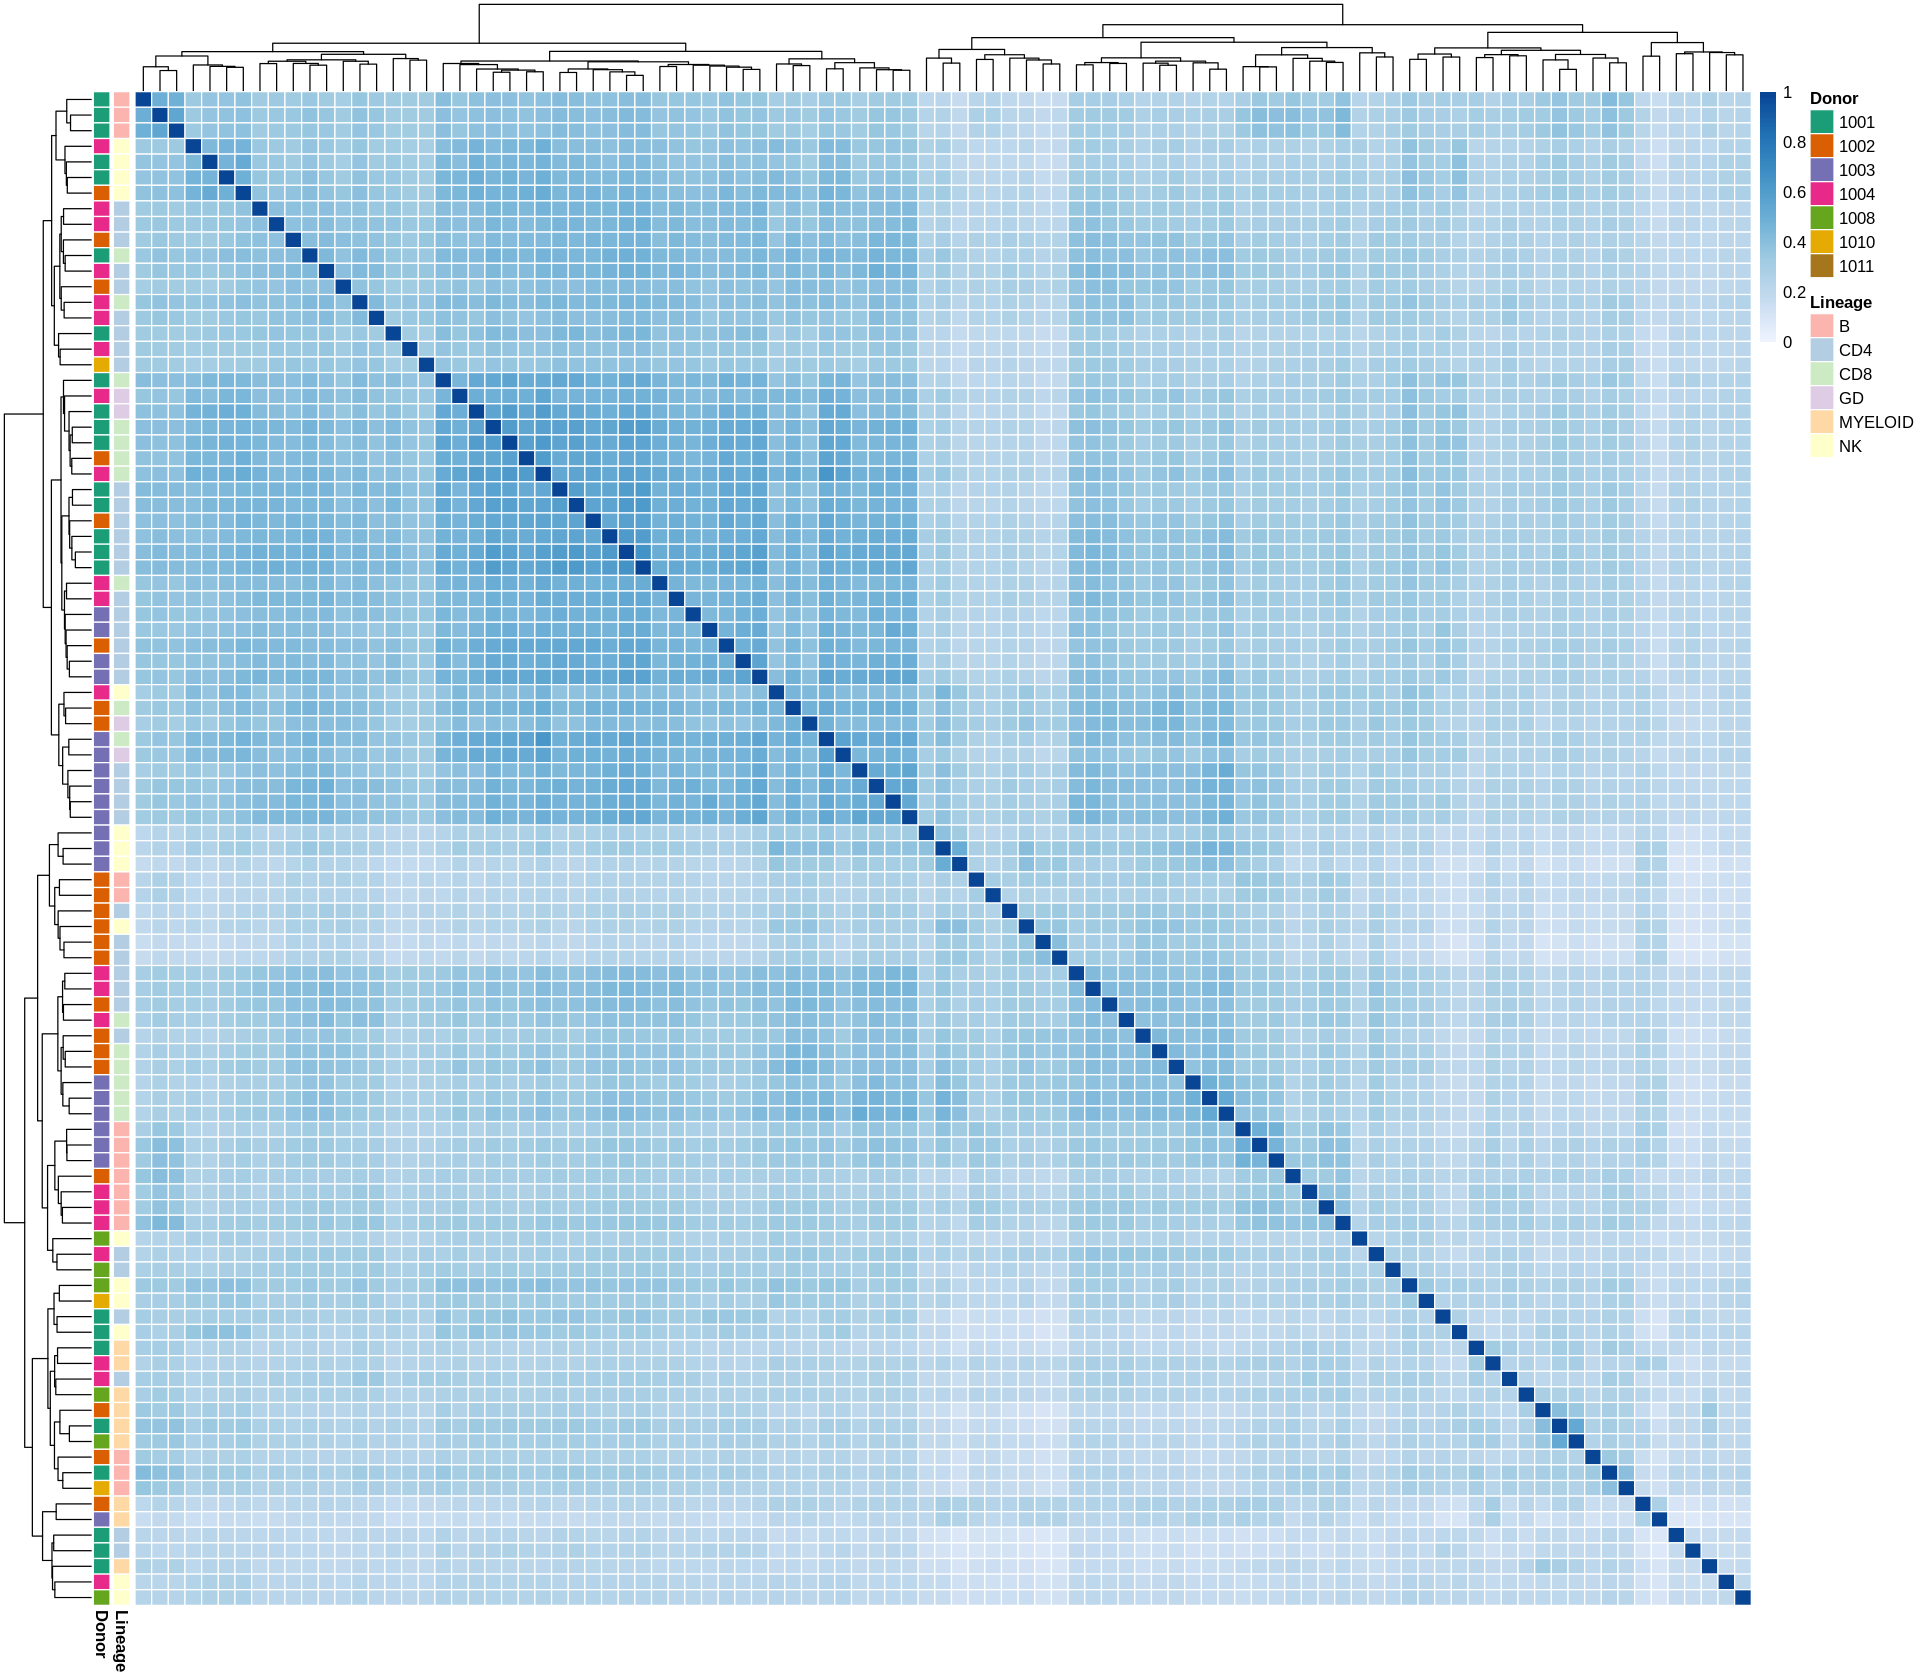

In [6]:
options(repr.plot.width=16, repr.plot.height=14)
pheatmap(
    jaccard.mtx.no.treatment,
    color=colorRampPalette(brewer.pal(7, "Blues"))(100),
    breaks=seq(0, 1, length.out=101),
    annotation_row=annotation,
    annotation_colors=annotation.cols,
    show_rownames=F, show_colnames=F,
    border_color="white"
)

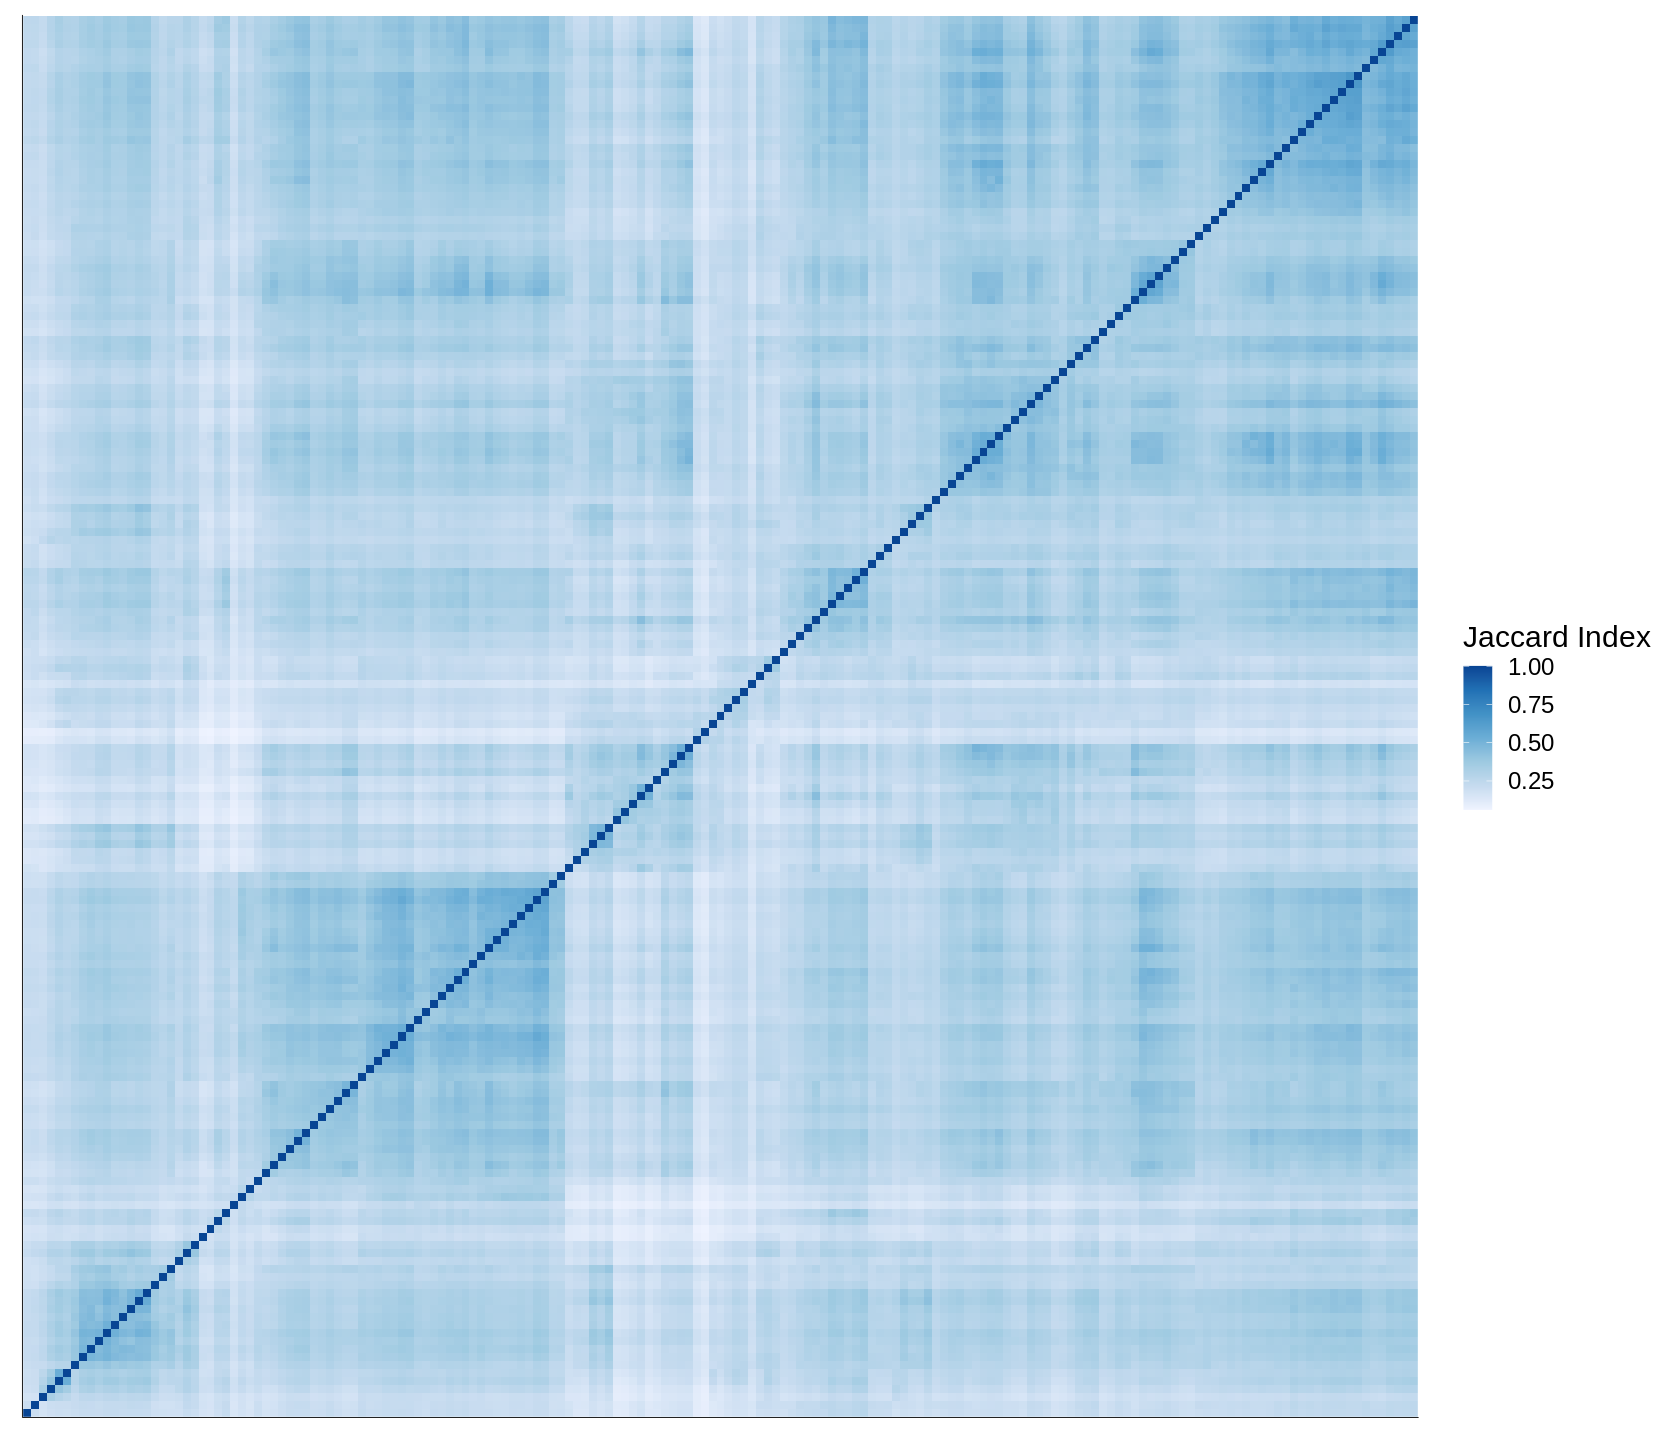

In [7]:
h <- hclust(as.dist(1 - jaccard.mtx))

options(repr.plot.width=14, repr.plot.height=12)
jaccard.info %>%
    dplyr::mutate(Sample.1=factor(Sample.1, levels=rownames(jaccard.mtx)[h$order])) %>%
    dplyr::mutate(Sample.2=factor(Sample.2, levels=colnames(jaccard.mtx)[h$order])) %>%
    ggplot() +
    geom_raster(aes(x=Sample.1, y=Sample.2, fill=Jaccard.Index)) +
    scale_fill_distiller("Jaccard Index", palette="Blues", direction=1) +
    ggplot_theme +
    theme(axis.text=element_blank(), axis.title=element_blank(), axis.ticks=element_blank(), legend.position="right")
ggsave("03_Functional_Interpretation/results/peak_jaccard_matrix.svg", width=14, height=12)

## Multidimensional Scaling

Since the Jaccard Index is a measure of similarity, it cannot be subjected to analysis using Principal Component Analysis (PCA) directly. Multidimensional scaling (MDS) is a more general approach to visualizing similarity between samples in a lower-dimensional space. MDS has the advantage of using distance matrices rather than the sample matrix. Non-metric MDS does not assume that the distance measure is within a metric space.

In [14]:
fit <- isoMDS(as.dist(1 - jaccard.mtx), k=2)

initial  value 35.424393 
iter   5 value 20.830750
iter  10 value 18.419960
iter  15 value 17.951925
final  value 17.874577 
converged


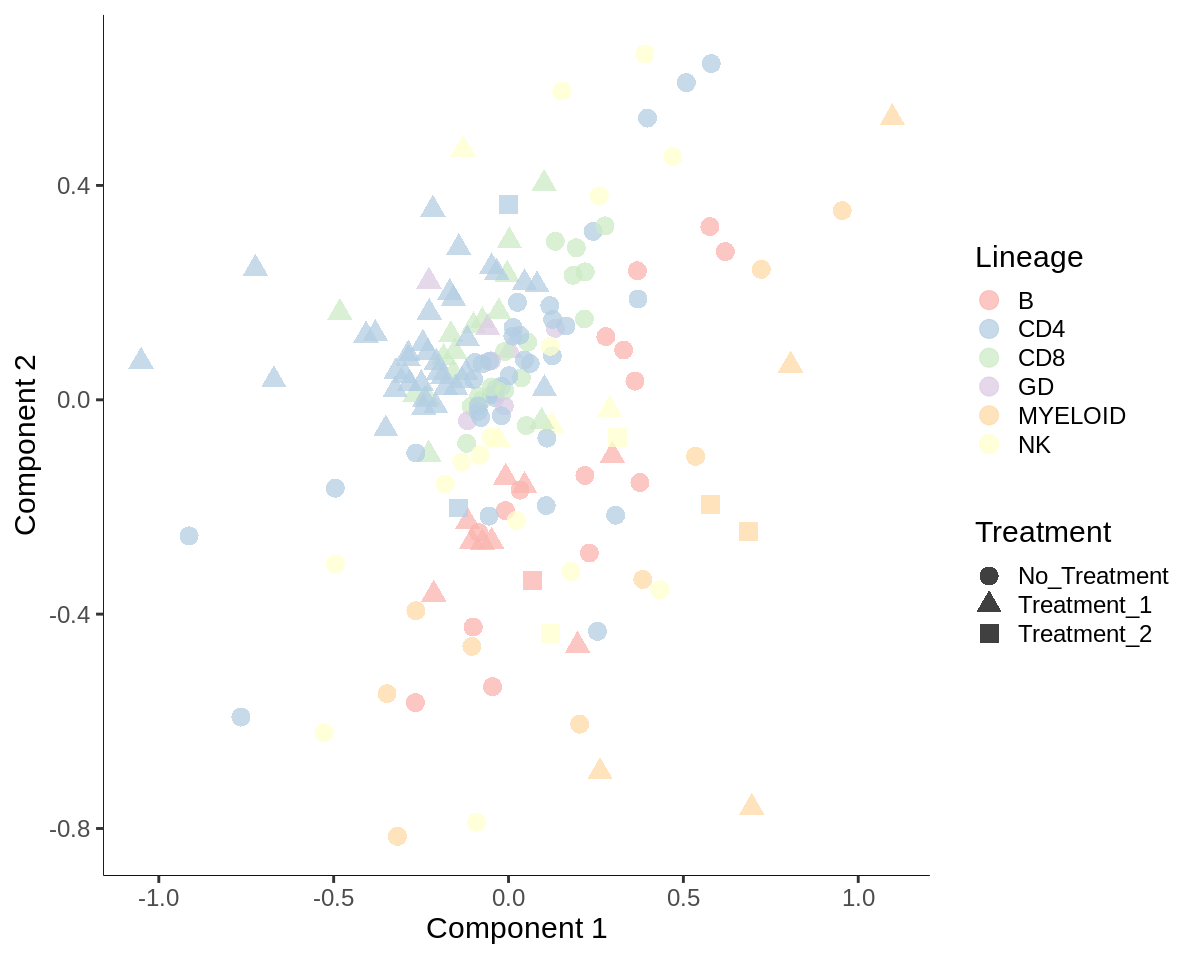

In [22]:
options(repr.plot.width=10, repr.plot.height=8)
fit$points %>%
    as.data.frame() %>%
    dplyr::select(Component.1=1, Component.2=2) %>%
    dplyr::bind_cols(sample.info) %>%
    ggplot() +
    geom_point(aes(x=Component.1, y=Component.2, color=Lineage, shape=Treatment), size=I(5), alpha=0.75) +
    scale_color_brewer(palette="Dark2") +
    xlab("Component 1") + ylab("Component 2") +
    ggplot_theme +
    theme(legend.position="right")
ggsave("03_Functional_Interpretation/results/peak_jaccard_mds.svg", width=10, height=8)